In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input


# from google.colab import drive
# drive.mount("/content/gdrive")

Using TensorFlow backend.


In [2]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_image_aug = drive_base_path + "dataset/ISIC2018_VGG16_Training_AUG/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [3]:
directory_images = os.listdir(path_to_images)
image_file = directory_images[100]
image_file[:-4]

'ISIC_0033177'

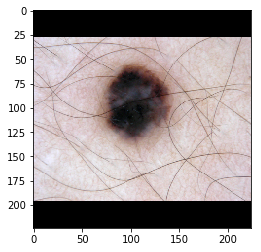

In [4]:
# all image sizes are 600x450
INPUT_SIZE = 224 # pad all input images

img = cv2.imread(path_to_images + image_file)
# parse BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
old_size = img.shape[:2] # height, width

# rescale
ratio = float(INPUT_SIZE)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# resize with new size
img = cv2.resize(img, (new_size[1], new_size[0])) # width, height
# plt.imshow(img)

# padding the image to make it a square
delta_w = INPUT_SIZE - new_size[1]
delta_h = INPUT_SIZE - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                            value=color)

plt.imshow(new_img)

In [8]:
def create_train_test(path_to_images, path_to_description, test_split=0.0):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)
        
        X_train.append(new_img)
    
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_train.append([int(float(x)) for x in row[1:]])
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_split, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [ ]:
X_train, X_test, y_train, y_test = create_train_test(path_to_images, path_to_description)

In [ ]:
with open(drive_base_path + "dataset/pickled-data/VGG16_ISIC_2018_data.pkl", "wb") as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)

In [5]:
with open(drive_base_path + "dataset/pickled-data/VGG16_ISIC_2018_data.pkl", "rb") as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [6]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

datagen.fit(X_train[2000:3000])

In [13]:
x, y = next(datagen.flow(X_train, y_train, save_to_dir=path_to_image_aug))

In [7]:
print("Training X Size", X_train.shape)
print("Training Y Size (Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofiroma, Vascular Lesion)", y_train.shape)
for i in range(5):
    print(X_train[i].shape, y_train[i])

Training X Size (10015, 224, 224, 3)
Training Y Size (Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofiroma, Vascular Lesion) (10015, 7)
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [1 0 0 0 0 0 0]


In [8]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=RMSprop(lr=1e-5), 
              metrics=["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
batch_size = 32
epochs = 2
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs, verbose=1, shuffle=True)

Epoch 1/2
313/312 [==============================] - 107s 343ms/step - loss: 1.4064 - acc: 0.6793
Epoch 2/2
313/312 [==============================] - 101s 323ms/step - loss: 0.9273 - acc: 0.7733


In [10]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True

# for layer in model.layers:
#     print(layer, layer.trainable)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_1
20 dense_1
21 dense_2
22 dense_3


In [11]:
model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])
epochs = 10
batch_size = 32
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(X_train) / batch_size, 
                              epochs=epochs, verbose=1, 
                              shuffle=True)
model.save_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Epoch 1/10
313/312 [==============================] - 119s 379ms/step - loss: 0.2486 - acc: 0.9178
Epoch 2/10
313/312 [==============================] - 115s 369ms/step - loss: 0.2051 - acc: 0.9308
Epoch 3/10
313/312 [==============================] - 116s 369ms/step - loss: 0.2626 - acc: 0.9124
Epoch 4/10
313/312 [==============================] - 115s 368ms/step - loss: 0.2785 - acc: 0.9066
Epoch 5/10
313/312 [==============================] - 115s 369ms/step - loss: 0.2600 - acc: 0.9133
Epoch 6/10
313/312 [==============================] - 115s 369ms/step - loss: 0.2204 - acc: 0.9225
Epoch 7/10
313/312 [==============================] - 115s 368ms/step - loss: 0.2269 - acc: 0.9223
Epoch 8/10
313/312 [==============================] - 115s 368ms/step - loss: 0.2029 - acc: 0.9286
Epoch 9/10
313/312 [==============================] - 115s 368ms/step - loss: 0.1967 - acc: 0.9316
Epoch 10/10
313/312 [==============================] - 115s 367ms/step - loss: 0.1965 - acc: 0.9301


OSError: Unable to create file (unable to open file: name = '../models/VGG16_ISIC_cnn.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [13]:
model.save_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')

{'loss': [0.24857756242312257, 0.2051636918174048, 0.2626307909451778, 0.2785413482898304, 0.2599777981322733, 0.22044212716374467, 0.22690724231455248, 0.20287151350804822, 0.19674070364257662, 0.1965214108794377], 'acc': [0.9178232651023465, 0.9308037943085372, 0.9124313529824473, 0.9066400399460414, 0.9133300049925113, 0.9225162256674593, 0.9223165252240848, 0.928607089276678, 0.9316025960165681, 0.9301048427418477]}


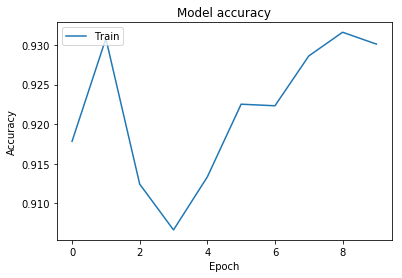

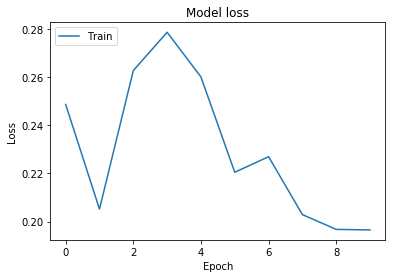

In [17]:
# Plot Training and Validation Accuracy
print(history.history)
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Validation_Input/"

ISIC_0034383


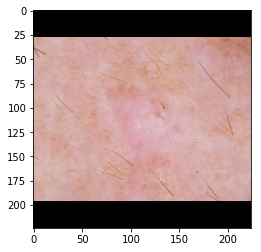

In [19]:
list_of_images = os.listdir(path_to_images)
filename = list_of_images[0]
print(filename[:-4])
input_size = 224

image = cv2.imread(path_to_images + filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
old_size = image.shape[:2]

ratio = float(input_size)/max(old_size)
new_size = tuple([int(x * ratio) for x in old_size])

image = cv2.resize(image, (new_size[1], new_size[0]))

delta_w = input_size - new_size[1]
delta_h = input_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                             cv2.BORDER_CONSTANT, value=color)

plt.imshow(new_img)


In [20]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)

#         arr = np.array(image)
        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [21]:
x, names = preprocess_images(path_to_images)

In [23]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

datagen.fit(x)

X Shape (193, 224, 224, 3)
Name Shape (193, 1)


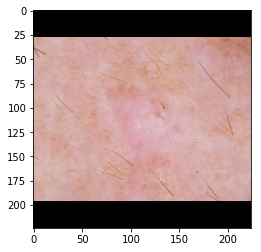

In [25]:
print("X Shape", x.shape)
plt.imshow(x[0])
print("Name Shape", names.shape)

In [26]:
model.load_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')

In [27]:
predictions = model.predict_generator(datagen.flow(x, batch_size=1))
classes = (predictions > 0.5).astype(np.float)
print(classes.shape)

(193, 7)


In [28]:
final_output = np.concatenate((names, classes), axis=1)
final_output.shape

(193, 8)

In [30]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)